In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [2]:
from keras import backend as K
K.clear_session()

with tf.Session() as sess:
        sess = tf.Session()
        K.set_session(sess)

Using TensorFlow backend.


In [3]:
init_op = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init_op)

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11915461981339822995, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9202108990
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15905204604982008007
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [2]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D
from keras.applications.xception import Xception, preprocess_input
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline

/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)


In [3]:
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import keras.backend as K

In [4]:
train_dir = 'data/train'
validation_dir = 'data/validation'

In [5]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/train 0
data/train/MEL 3308
data/train/DF 4152
data/train/BKL 3275
data/train/BCC 4773
data/train/VASC 3488
data/train/AKIEC 3856
data/train/NV 4975


In [6]:
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))

data/validation 0
data/validation/MEL 1664
data/validation/DF 1632
data/validation/BKL 1479
data/validation/BCC 1692
data/validation/VASC 1484
data/validation/AKIEC 1552
data/validation/NV 1730


In [7]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training

batch_size = 8

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)


# target_size = (height, width)
target_size = (224, 224)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size = batch_size,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = False)

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        batch_size = batch_size,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = False)

Found 27827 images belonging to 7 classes.
Found 11233 images belonging to 7 classes.


In [8]:
## Intilizing variables
output_classes = 7

epochs = 50
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)

In [12]:
from keras.applications import DenseNet201
model = DenseNet201(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)

from keras.models import Model
# creating the final model 
model_final = Model(input = model.input, output = predictions)



model_final.compile(loss='categorical_crossentropy',
              optimizer= adam_opt,
              metrics=['accuracy'])

c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [13]:
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

conv5_block24_1_conv (Conv2D)   (None, 7, 7, 128)    208896      conv5_block24_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block24_1_bn (BatchNormal (None, 7, 7, 128)    512         conv5_block24_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block24_1_relu (Activatio (None, 7, 7, 128)    0           conv5_block24_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block24_2_conv (Conv2D)   (None, 7, 7, 32)     36864       conv5_block24_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block24_concat (Concatena (None, 7, 7, 1664)   0           conv5_block23_concat[0][0]       
                                                                 conv5_block24_2_conv[0][0]       
__________

In [14]:
history = model_final.fit_generator(train_generator,
    steps_per_epoch=2048,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1024)

Epoch 1/50


c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2048/2048 [==============================] - 757s 370ms/step - loss: 1.8341 - acc: 0.5303 - val_loss: 0.9983 - val_acc: 0.7368
Epoch 2/50
2048/2048 [==============================] - 705s 344ms/step - loss: 1.1640 - acc: 0.7123 - val_loss: 0.8200 - val_acc: 0.7977
Epoch 3/50
2048/2048 [==============================] - 710s 347ms/step - loss: 0.9475 - acc: 0.7756 - val_loss: 0.7142 - val_acc: 0.8272
Epoch 4/50
2048/2048 [==============================] - 728s 355ms/step - loss: 0.7818 - acc: 0.8227 - val_loss: 0.6506 - val_acc: 0.8560
Epoch 5/50
2048/2048 [==============================] - 712s 348ms/step - loss: 0.6705 - acc: 0.8531 - val_loss: 0.6289 - val_acc: 0.8538
Epoch 6/50
2048/2048 [==============================] - 739s 361ms/step - loss: 0.5831 - acc: 0.8797 - val_loss: 0.5738 - val_acc: 0.8740
Epoch 7/50
2048/2048 [==============================] - 710s 347ms/step - loss: 0.5155 - acc: 0.8958 - val_loss: 0.5750 - val_acc: 0.8734
Epoch 8/50
2048/2048 [=======================

In [17]:
score = model_final.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.4812984025478363
Test Accuracy:  0.9225


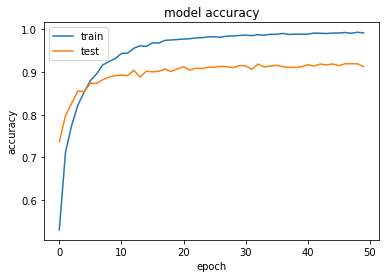

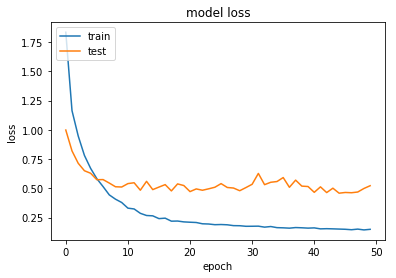

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [22]:
indexlabel

{0: 'AKIEC', 1: 'BCC', 2: 'BKL', 3: 'DF', 4: 'MEL', 5: 'NV', 6: 'VASC'}

In [16]:
predicts = model_final.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

/home/sara/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:988: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/sara/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:996: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1405/1404 [==============================] - 4610s 3s/step
No of errors = 1/11233


/home/sara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
predict_class = np.argmax(predicts, axis=1)

In [31]:
len(predict_class)

11233

In [26]:
truth = validation_generator.classes


In [29]:
len(truth)

11233

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix')

ValueError: Classification metrics can't handle a mix of multiclass and unknown targets

In [22]:
model.save('models/3.DenseNet-Dropout-Model.h5')
model.save_weights('models/3.DenseNet-Dropout-Weights.h5')

In [13]:
from keras.models import load_model
model_final = load_model("models/3.DenseNet-Dropout-Model.h5", custom_objects={'fmeasure': fmeasure,  'recall': recall, 'precision': precision })
model_final.load_weights("models/3.DenseNet-Dropout-Weights.h5")

/home/sara/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))    

plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

ValueError: Classification metrics can't handle a mix of multiclass and unknown targets

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [10]:
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)


In [14]:
from keras.applications import DenseNet201
model = DenseNet201(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)

from keras.models import Model
# creating the final model 
model_final = Model(input = model.input, output = predictions)



model_final.compile(loss='categorical_crossentropy',
              optimizer= adam_opt,
              metrics = ["categorical_accuracy", fmeasure, recall, precision])

c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [15]:
history = model_final.fit_generator(train_generator,
    steps_per_epoch=2048,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1024)

Epoch 1/50


c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2048/2048 [==============================] - 747s 365ms/step - loss: 1.8297 - categorical_accuracy: 0.5331 - fmeasure: 0.5235 - recall: 0.4846 - precision: 0.5790 - val_loss: 0.9600 - val_categorical_accuracy: 0.7405 - val_fmeasure: 0.7336 - val_recall: 0.6854 - val_precision: 0.7976
Epoch 2/50
2048/2048 [==============================] - 716s 350ms/step - loss: 1.1574 - categorical_accuracy: 0.7150 - fmeasure: 0.7128 - recall: 0.6844 - precision: 0.7486 - val_loss: 0.7456 - val_categorical_accuracy: 0.8180 - val_fmeasure: 0.8161 - val_recall: 0.7839 - val_precision: 0.8568
Epoch 3/50
2048/2048 [==============================] - 723s 353ms/step - loss: 0.9255 - categorical_accuracy: 0.7836 - fmeasure: 0.7824 - recall: 0.7597 - precision: 0.8105 - val_loss: 0.6964 - val_categorical_accuracy: 0.8386 - val_fmeasure: 0.8360 - val_recall: 0.8148 - val_precision: 0.8619
Epoch 4/50
2048/2048 [==============================] - 724s 354ms/step - loss: 0.7685 - categorical_accuracy: 0.8252 - fme

Epoch 29/50
2048/2048 [==============================] - 723s 353ms/step - loss: 0.1743 - categorical_accuracy: 0.9835 - fmeasure: 0.9838 - recall: 0.9827 - precision: 0.9850 - val_loss: 0.3945 - val_categorical_accuracy: 0.9185 - val_fmeasure: 0.9218 - val_recall: 0.9153 - val_precision: 0.9293
Epoch 30/50
2048/2048 [==============================] - 725s 354ms/step - loss: 0.1672 - categorical_accuracy: 0.9861 - fmeasure: 0.9859 - recall: 0.9852 - precision: 0.9867 - val_loss: 0.3991 - val_categorical_accuracy: 0.9182 - val_fmeasure: 0.9200 - val_recall: 0.9153 - val_precision: 0.9256
Epoch 31/50
2048/2048 [==============================] - 725s 354ms/step - loss: 0.1619 - categorical_accuracy: 0.9871 - fmeasure: 0.9870 - recall: 0.9862 - precision: 0.9879 - val_loss: 0.3753 - val_categorical_accuracy: 0.9262 - val_fmeasure: 0.9267 - val_recall: 0.9214 - val_precision: 0.9329
Epoch 32/50
2048/2048 [==============================] - 723s 353ms/step - loss: 0.1609 - categorical_accurac

In [24]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [25]:
score = model_final.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])
print ('fmeasure: ', score[2])
print ('Recall: ', score[3])
print ('Precision: ', score[4])

Test Score:  0.30734893813729286
Test Accuracy:  0.94
fmeasure:  0.9378095030784607
Recall:  0.9325
Precision:  0.9442857146263123


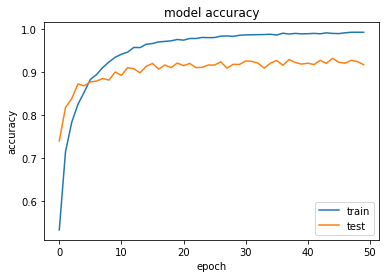

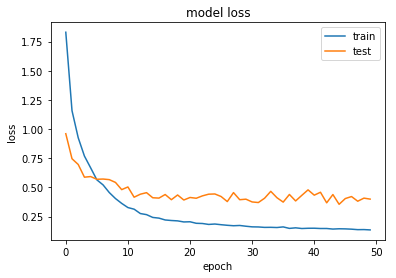

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()